# Mercari Price Suggestion Challenge

For the Kaggle competition "Mercari Price Suggestion Challenge", we were tasked to write code to predict prices. This is my suggestion. There are three steps: 

1. EDA
2. Data Engineering
3. Machine Learning

The challenge was completed in mid-February of 2018 and I scored among the top 60% of over 2300 sbumission. This was my first ever Kaggle competition. 


## Exploratory Data Analysis

The data is organized like so:

- train_id or test_id - the id of the listing
- name - the title of the listing
- item_condition_id - the condition of the items provided by the seller
- category_name - category of the listing
- brand_name
- price - the price that the item was sold for, also the **target variable**
- shipping - 1 if shipping fee is paid by seller and 0 by buyer
- item_description - the full description of the item

The first natural step is to look at the distribituion of prices.


In [1]:
import pandas as pd
import numpy as np
import string
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor

test=pd.read_csv("C:/Users/Malte/Documents/My repositories/Mercari/test.tsv",sep="\t")

train=pd.read_csv("C:/Users/Malte/Documents/My repositories/Mercari/train.tsv",sep="\t")

train.fillna("",inplace=True)
test.fillna("",inplace=True)

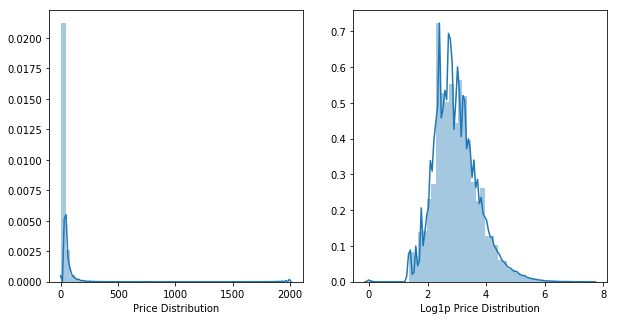

In [2]:
fig,(ax) = plt.subplots(1,2,figsize=(10,5))
sns.distplot(train["price"],ax=ax[0],axlabel="Price Distribution")
sns.distplot(np.log1p(train["price"]),ax=ax[1],axlabel="Log1p Price Distribution")

Looking at the price distribution we gain two insights:

1. The bulk of the prices are lower.
2. Transforming the prices logarythmically, we can see that that the distribtuion is slightly positively skewed. 

Let's look at prices now and how they are affected whether shipping is included or not.

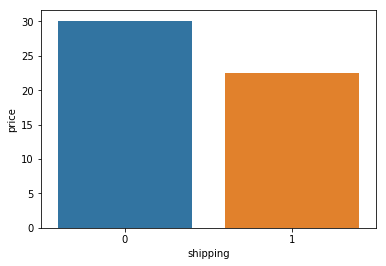

In [3]:
sns.barplot(x="shipping",y="price",data=train,ci=None)

Shipping does seem to hae somewhat an effect on shipping. 

What about the condition of the item.

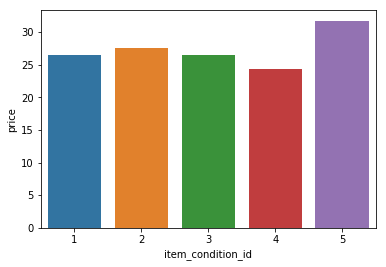

In [4]:
sns.barplot(x="item_condition_id",y="price",data=train,ci=None)

The item condition does not have the expected effect on prices.

We are lookin at the item prices in a very broad way. Let's look at categories more in detail in order to dig deeper. The data comes with uncategorized category names, that is, each category looks like the following:

In [5]:
print train["category_name"][:10]

0                                    Men/Tops/T-shirts
1    Electronics/Computers & Tablets/Components & P...
2                          Women/Tops & Blouses/Blouse
3                   Home/Home Décor/Home Décor Accents
4                              Women/Jewelry/Necklaces
5                                    Women/Other/Other
6                             Women/Swimwear/Two-Piece
7                      Sports & Outdoors/Apparel/Girls
8                      Sports & Outdoors/Apparel/Girls
9             Vintage & Collectibles/Collectibles/Doll
Name: category_name, dtype: object


In order to work with the categories more usefully, we have to change the data to seperate the main category and the two sub-categories. 

In [6]:
def cat_split(row):
    try:
        txt1, txt2, txt3 = row.split('/')
        return row.split('/')
    except:
        return ("No Label", "No Label", "No Label")

train["cat_1"], train["cat_2"], train["cat_3"] = zip(*train["category_name"].apply(lambda val: cat_split(val)))

We can now look at the categories and price differences in more detail.

[Text(0.5,0,u'Main Catgory')]

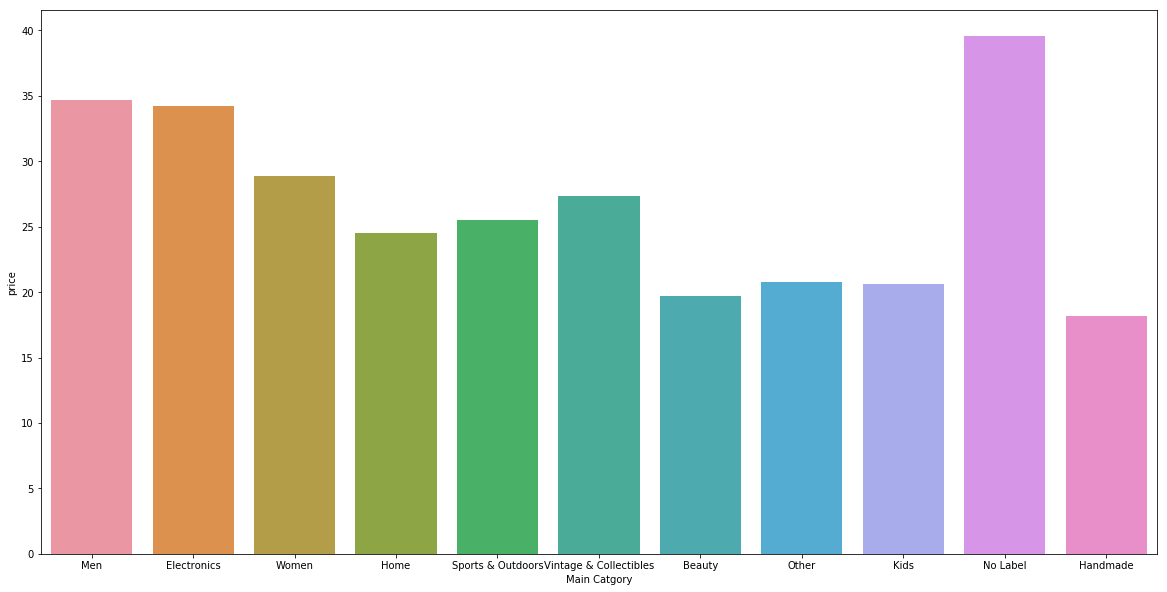

In [7]:
fig,ax=plt.subplots(1,1,figsize=(20,10))
sns.barplot(x="cat_1",y="price",data=train,ax=ax,ci=None)
ax.set(xlabel="Main Catgory")

There does seem to be quite a variety of prices between the categories.

Since there are many more subcategories, we are going to look at the top 10 subcategory 1 and subcategory 2 by occurence and their average price.

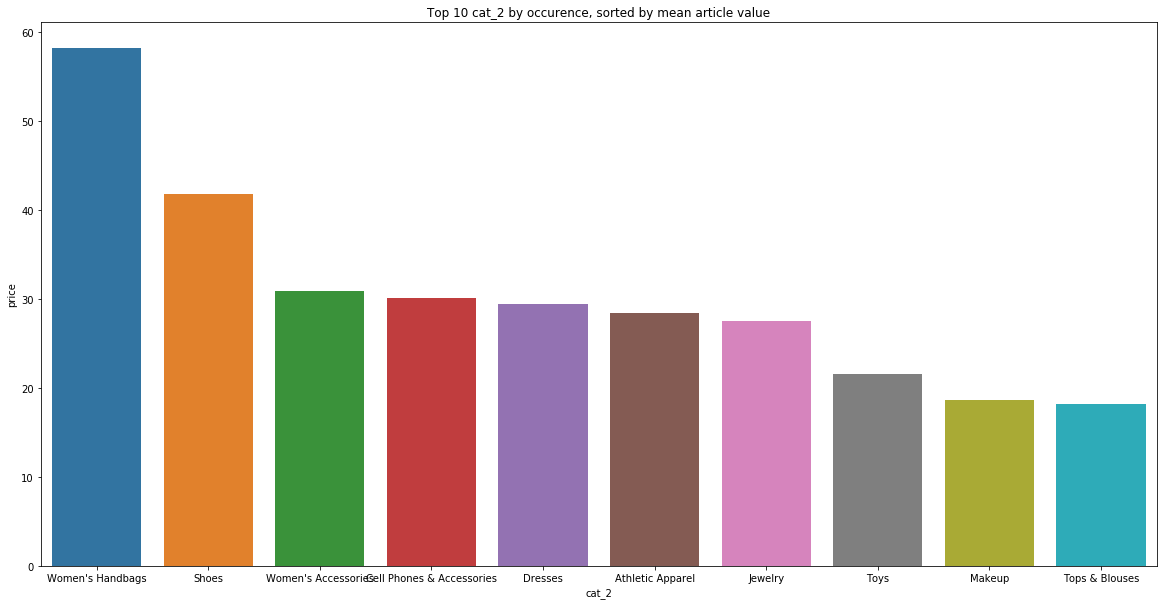

In [8]:
def top_x_by_mean_price(df,cat,x):
    most_freq_items=df[cat].value_counts()
    most_freq_items=list(most_freq_items.index[:x])
    if "" in most_freq_items:
        most_freq_items.remove("")
    df_top_10=df[df[cat].isin(most_freq_items)]
    df_top_10=df_top_10.groupby(cat)
    df_top_10_by_price= df_top_10["price"].mean().reset_index()
    df_top_10_by_price.sort_values("price",ascending=False,inplace=True)
    fig,ax=plt.subplots(figsize=(x+10,10))
    ax.set_title("Top {} {} by occurence, sorted by mean article value".format(str(x),cat))
    sns.barplot(x=cat,y="price",data=df_top_10_by_price,ax=ax,ci=None)
    
top_x_by_mean_price(train,"cat_2",10)


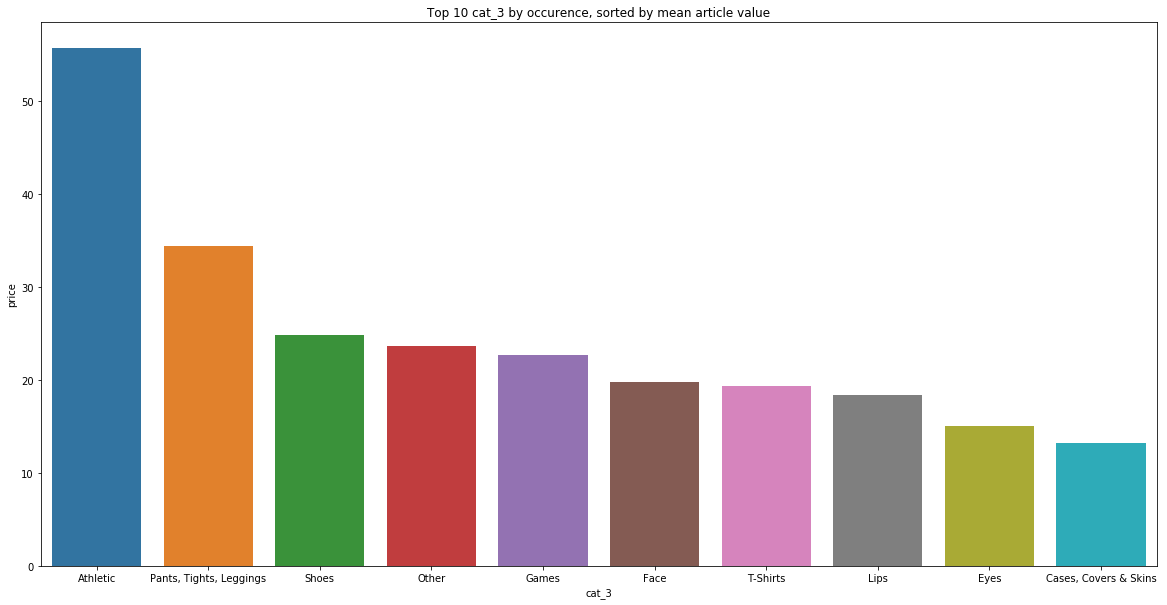

In [9]:
def top_x_by_mean_price(df,cat,x):
    most_freq_items=df[cat].value_counts()
    most_freq_items=list(most_freq_items.index[:x])
    if "" in most_freq_items:
        most_freq_items.remove("")
    df_top_10=df[df[cat].isin(most_freq_items)]
    df_top_10=df_top_10.groupby(cat)
    df_top_10_by_price= df_top_10["price"].mean().reset_index()
    df_top_10_by_price.sort_values("price",ascending=False,inplace=True)
    fig,ax=plt.subplots(figsize=(x+10,10))
    ax.set_title("Top {} {} by occurence, sorted by mean article value".format(str(x),cat))
    sns.barplot(x=cat,y="price",data=df_top_10_by_price,ax=ax,ci=None)
    
top_x_by_mean_price(train,"cat_3",10)


Categories definitely play a role, which is why we need to prepare the mfor our machine learning algorithm.

In [10]:
def categorizer(df,col):
    df[col]=df[col].astype("category")
    df[col]=df[col].cat.codes
    return df

for e in ["brand_name","cat_1","cat_2","cat_3"]:
    categorizer(train,e)

These kind of platforms also rely on descriptions of their products. Let's take a look first whether having descriptions or not makes a difference in price.

<function matplotlib.pyplot.show>

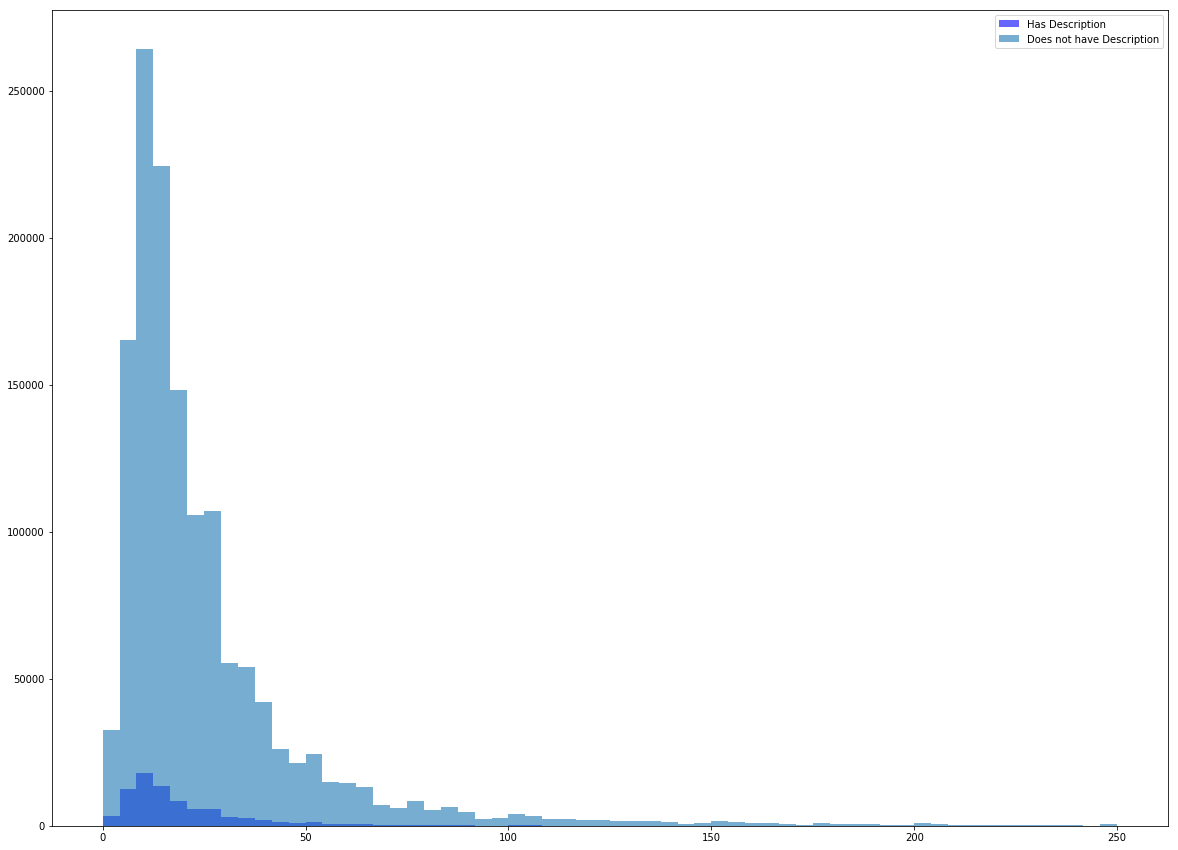

In [11]:
def described(x):
    if "description yet" in x:
        return 1
    else:
        return 0
    
train["has_description"]=train["item_description"].apply(lambda x: described(x))

plt.figure(figsize=(20,15))
plt.hist(train["price"].loc[train["has_description"]==True],label="Has Description",bins=60,color="blue",alpha=0.6,range=[0,250])
plt.hist(train["price"].loc[train["has_description"]==False],label="Does not have Description",bins=60,alpha=0.6,range=[0,250])
plt.legend()
plt.show

The distributions are smiliar, which tells us that there are simply more items without descriptions. Let's look at the lengths of the descriptions now.

In [12]:
train["desc_length"]=train["item_description"].apply(lambda x: len(x))

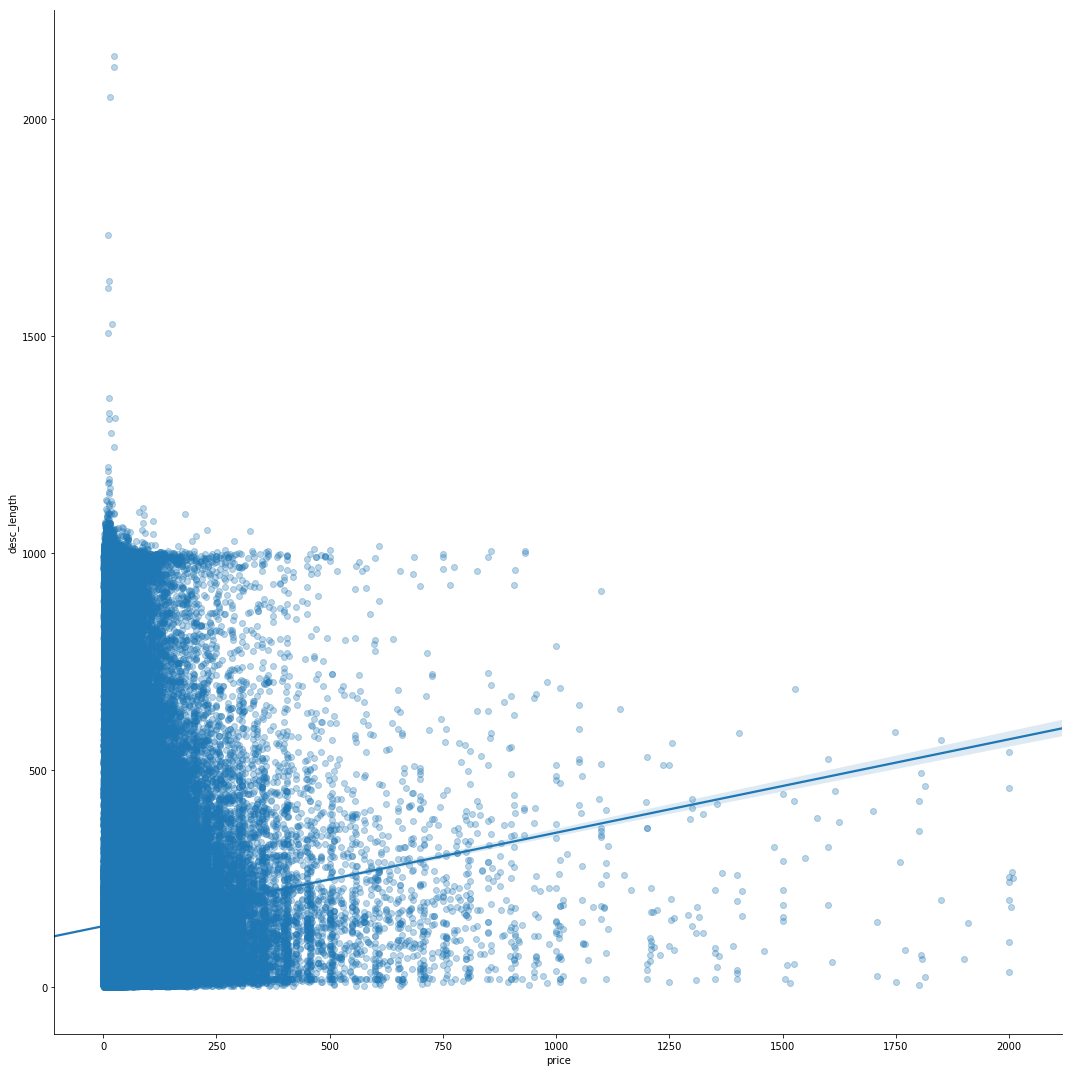

In [13]:
sns.lmplot("price","desc_length",data=train,fit_reg=True,scatter_kws={'alpha':0.3},aspect=1,size=15)

There seems to be a minimal correlation at best. 

One more thing to examine is the term frequency-inverse document frequency, that is how often a word appears relative to the overall number of words in the document. Another way of looking at it is, how rare a word is. Let's start with a wordclodu first.

(-0.5, 1439.5, 1079.5, -0.5)

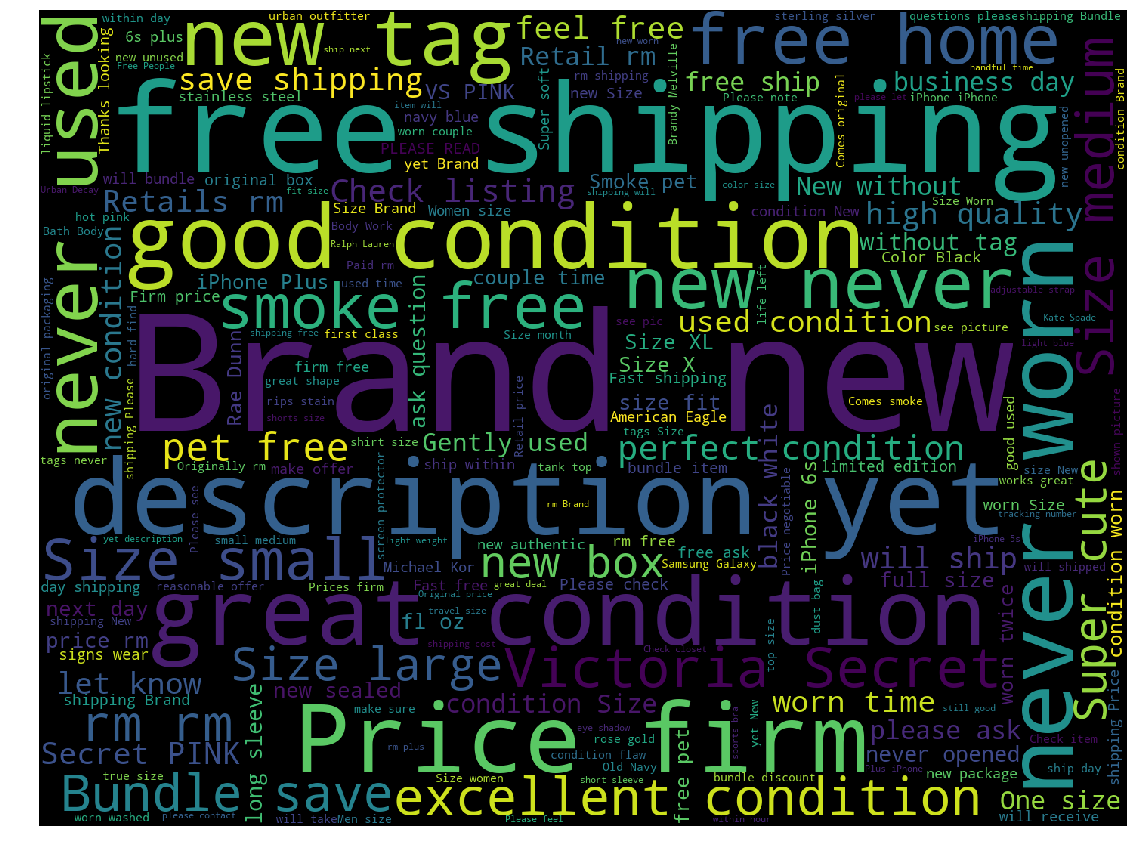

In [14]:
cloud = WordCloud(width=1440, height=1080).generate(" ".join(train['item_description'].astype(str)))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')

Now let's look at the actual tfidf scores. 

In [15]:
def compute_tfidf(desc):
    tfidf_score=0
    word_count=0
    for w in desc.lower().split():
        if w in tfidf_dict:
            tfidf_score+=tfidf_dict[w]
        word_count+=1
    if word_count>0:
        return tfidf_score
    else:
        return 0
    
tfidf=TfidfVectorizer(strip_accents="ascii",min_df=5,lowercase=True,token_pattern=r'\w+',analyzer="word",ngram_range=(1,3),stop_words="english")
tfidf.fit_transform(train["item_description"].apply(str))
tfidf_dict=dict(zip(tfidf.get_feature_names(),tfidf.idf_))
train["tfidf"]=train["item_description"].apply(lambda x: compute_tfidf(x))

C:\Users\Malte\Anaconda2\lib\site-packages\ipykernel_launcher.py:5: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  """


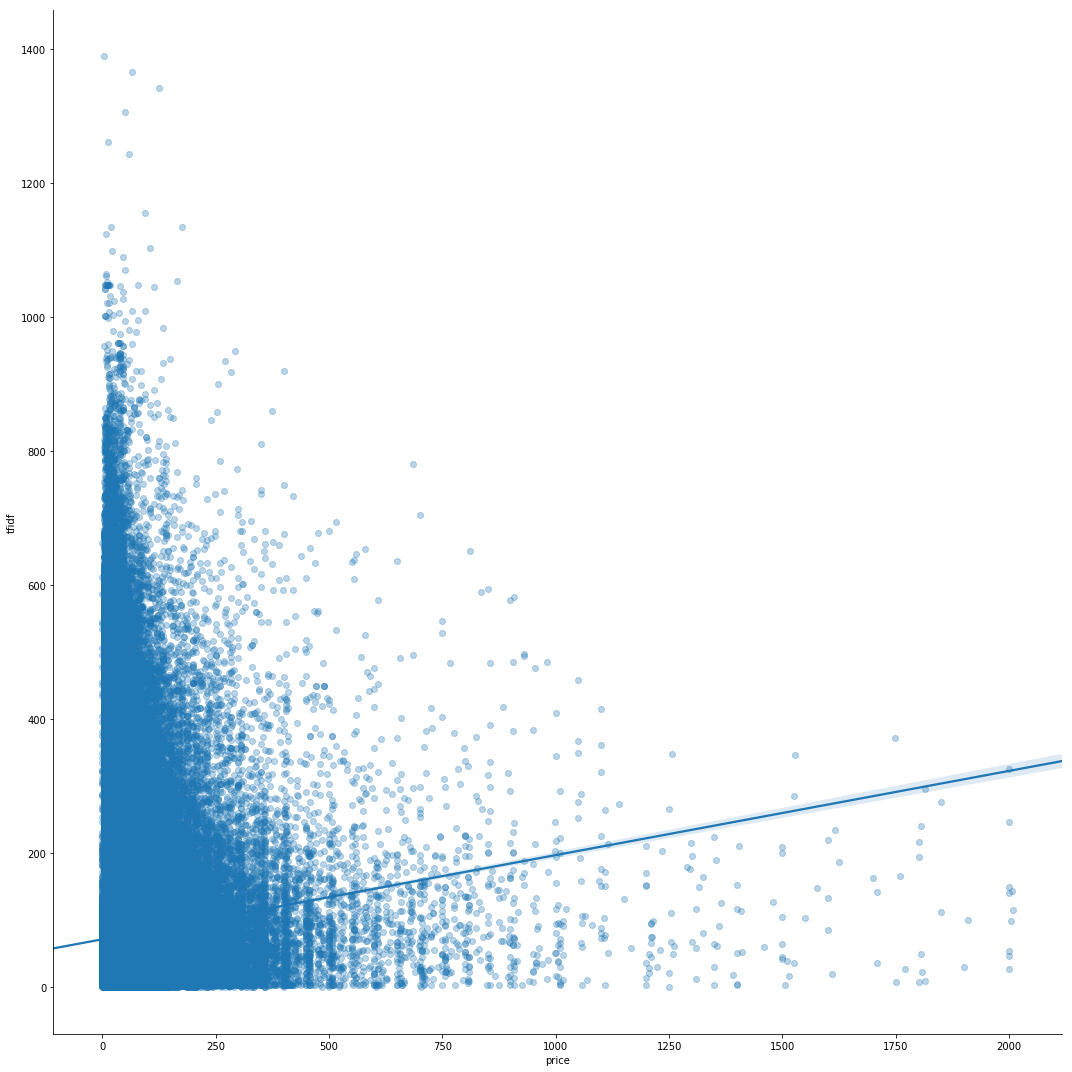

In [16]:
sns.lmplot("price","tfidf",data=train,fit_reg=True,scatter_kws={'alpha':0.3},aspect=1,size=15)

Though this looks similar to the description length / price distribution, we have more of a cluster in the bottom, so we will include this in our algorithm. 

## Machine Learning

I decided to use a relatively simple random forest algorithm and since I was pressed for time, I didn't get to play around with the parameters for better results. Nonetheless, I was pleased with it's performance and it actually improved markedly once it was applied to the full training set in the second phase of the competition. 

Firstly though, we have to do the same data engineering on the test set that we did on the training set. I will include all the funtions again for clarity. 

In [17]:
def cat_split(row):
    try:
        txt1, txt2, txt3 = row.split('/')
        return row.split('/')
    except:
        return ("No Label", "No Label", "No Label")

def described(x):
    if "description yet" in x:
        return 1
    else:
        return 0

def compute_tfidf(desc):
    tfidf_score=0
    word_count=0
    for w in desc.lower().split():
        if w in tfidf_dict:
            tfidf_score+=tfidf_dict[w]
        word_count+=1
    if word_count>0:
        return tfidf_score
    else:
        return 0

def categorizer(df,col):
    df[col]=df[col].astype("category")
    df[col]=df[col].cat.codes
    return df


test["cat_1"], test["cat_2"], test["cat_3"] = zip(*test["category_name"].apply(lambda val: cat_split(val)))
test["desc_length"]=test["item_description"].apply(lambda x: len(x))
test["has_description"]=test["item_description"].apply(lambda x: described(x))
tfidf=TfidfVectorizer(strip_accents="ascii",min_df=5,lowercase=True,token_pattern=r'\w+',analyzer="word",ngram_range=(1,3),stop_words="english")
tfidf.fit_transform(test["item_description"].apply(str))
tfidf_dict=dict(zip(tfidf.get_feature_names(),tfidf.idf_))
for e in ["brand_name","cat_1","cat_2","cat_3"]:
    categorizer(test,e)
test["tfidf"]=test["item_description"].apply(lambda x: compute_tfidf(x))

for e in [train,test]:
    e.drop(["name","category_name","item_description",],axis=1,inplace=True)

C:\Users\Malte\Anaconda2\lib\site-packages\ipykernel_launcher.py:18: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


We then do the preprocessing as well as the actual fitting of the classefier. Then I make the predictions and format them according to the competition guidelines. Again, I am using basic parameters here, the algortihm would have been much more precise if I would have had more time. 

In [18]:
train_price=train["price"].astype(int)
train.drop(["price"],axis=1,inplace=True)

train=preprocessing.scale(train)
test=preprocessing.scale(test)

clf=RandomForestRegressor()
clf.fit(train.astype(float),train_price)
pred=clf.predict(test.astype(float))

submission=pd.DataFrame(pred)
submission.index.rename("test_id",inplace=True)
submission.rename(index=str,columns={0:"price"},inplace=True)

# Acknowledgements

This was my first kaggle competition and I learned a ton from a lot of public kernels and the incredibly supportive and helpful community on kaggle. 